In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import Callback

import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar

from PIL import Image
import io

class SavePredictions(Callback):
    def __init__(self, x_val):
        self.x_val = x_val
        self.predictions = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Faz as previsões no conjunto de validação
        y_pred = self.model.predict(self.x_val)
        
        # Salva as previsões em uma lista
        self.predictions.append(y_pred)
        
        # Salva as previsões em um arquivo a cada 5 épocas
        if epoch % 10 == 0:
            np.save('solutions/din_1_fun_2_epoch{}.npy'.format(10000+epoch), y_pred)

def trimf(x,fuz):
    a,b,c = fuz
    rs = np.nan
    if x<a or x>c:
        rs = 0
    elif x>=a and x<=b:
        rs = (x-a)/(b-a)
    elif x>b and x<=c:
        rs = (c-x)/(c-b)
    return rs

def dinamica(u,x,t,T):
    tv = np.space(0,T,len(u))
    hs = tv[1]
    aux = np.interp(t,tv,hs*np.cumsum(u))
    return x+aux,x-aux

def construir_sol(t,z,u,fuz):
    rs = np.zeros(shape=(len(z),len(t)))
    u = t[1]*np.cumsum(u)
    for i,vt in enumerate(t):
        for j,vz in enumerate(z):
            rs[j,i] = trimf(vz-u[i],fuz[0],fuz[1],fuz[2])
    return rs

def sol_levels(u,fuz,nniv):
    niveis = np.linspace(0,1,nniv)
    xniveis = np.sort(np.concatenate([np.linspace(fuz[0],fuz[2],10*nniv),[fuz[1]]],dtype=float)).reshape(10*nniv+1,1)
    xpert = np.array([trimf(x,fuz) for x in xniveis]).reshape(len(xniveis),1)
    hs,n = 1/len(u),len(u)
    sol = hs*np.concatenate([[0],np.cumsum(u)])+xniveis
    Sup = np.zeros((nniv,n+1))
    Inf = np.zeros((nniv,n+1))
    for i in range(nniv):
        Sup[i,:] = np.max([sol[j] for j in range(len(xniveis)) if xpert[j]>=niveis[i]],axis=0)
        Inf[i,:] = np.min([sol[j] for j in range(len(xniveis)) if xpert[j]>=niveis[i]],axis=0)


    return [Inf, Sup]

def funcional(u,gamma, beta, e, x0, T,alpha):
    hs = T/len(u)
    w = hs*np.cumsum(u)
    phit = e*(6*w*w - 12*gamma*w + 12*x0*w + e*e + 6*gamma*gamma - 12*gamma*x0 + 6*x0*x0)/6
    Iu2 =  hs*np.sum(u*u)
    ju = 0.5*(1-alpha)*phit[-1]+0.5*alpha*hs*np.sum(phit)+0.5*beta*Iu2
    return ju


def minhas_metricas(gamma, beta, e, x0, T,alpha,lenInput):
    nniv = 100
    xniveis = np.sort(np.concatenate([np.linspace(x0-e,x0+e,nniv),[x0]],dtype=float)).reshape(nniv+1,1)
    xpert = np.array([trimf(x,[x0-e,x0,x0+e]) for x in xniveis]).reshape(nniv+1,1)
    t = np.linspace(0,T,lenInput)

    hs = T / lenInput


    def funcional(y_true, y_pred):
        
        D = hs*K.cumsum(y_pred, axis=1)+xniveis
        aD,ap = (D[:-1]+D[1:])/2, (xpert[:-1]+xpert[1:])/2  
        dD = K.cast(K.abs(xniveis[1:,:]-xniveis[:-1,:]),dtype=float)
        auxD = ((aD-gamma)**2)*ap

        phit = K.sum(auxD*dD,axis=0,keepdims=True)
        # print(y_pred[-1].shape)
        Iu2 =  hs*K.sum(y_pred*y_pred,axis=1,keepdims=True)
        Iphit = hs*K.sum(phit,keepdims=True)

        ju = 0.5*(1-alpha)*phit[-1][-1] + 0.5*alpha*Iphit+0.5*beta*Iu2

        return K.mean(ju)
    
    def loss_u(y_true, y_pred):
        H1 = alpha*e*(T-t)*(gamma-x0)
        intu = hs*K.sum(y_pred, axis=1, keepdims=True)
        aux2 = hs*K.cumsum(y_pred, axis=1)
        H2 = -alpha*e*hs*(K.sum(aux2, axis=1,keepdims=True)-K.cumsum(aux2, axis=1))
        H3 = e*(1-alpha)*(gamma-x0-intu)
        diff = H1+H2+H3-beta*y_pred

        # calculate the L2 norm for each example
        norma = K.sqrt(K.sum(K.square(diff), axis=1))/lenInput

        return K.mean(norma)
    
    def funcional2(y_true, y_pred):
        w = hs*K.cumsum(y_pred, axis=1)
        phit = e*(6*w*w - 12*gamma*w + 12*x0*w + e*e + 6*gamma*gamma - 12*gamma*x0 + 6*x0*x0)/6
        Iphit = hs*K.sum(phit,keepdims=True)
        Iu2 =  hs*K.sum(y_pred*y_pred,axis=1,keepdims=True)
        ju = 0.5*(1-alpha)*phit[-1][-1] + 0.5*alpha*Iphit+0.5*beta*Iu2
        return K.mean(ju)
    
    return funcional, loss_u, funcional2

In [12]:
# parâmetros
gamma = 0.0
beta = 1/4.0
e = 1.0
x0 = 5.0
T = 1.0
alpha = 0.5

# Dados da rede
n, n1 = 100, 5


# Dados de treinamento
X_train = np.linspace(0,T,n).reshape(1,n)
y_train = np.linspace(0,T,n).reshape(1,n)

funcional, loss_u,funcional2 = minhas_metricas(gamma, beta, e, x0, T,alpha, n)

model = Sequential()

model.add(InputLayer(input_shape=(n,)))
model.add(Dense(n1, activation='relu'))
model.add(Dense(n, activation='linear'))

model.compile(loss=funcional2, metrics = funcional, optimizer='adam')

# Treinando o modelo
# save_predictions = SavePredictions(X_train)
# model.fit(X_train, y_train, epochs=1001, callbacks=[save_predictions])
model.fit(X_train, y_train, epochs=1001)
u = model.predict(X_train).ravel()

Epoch 1/1001
1/1 [==============================] - 1s 1s/step - loss: 12.6781 - funcional: 12.6782
Epoch 2/1001
1/1 [==============================] - 0s 9ms/step - loss: 12.6610 - funcional: 12.6610
Epoch 3/1001
1/1 [==============================] - 0s 15ms/step - loss: 12.6447 - funcional: 12.6447
Epoch 4/1001
1/1 [==============================] - 0s 25ms/step - loss: 12.6293 - funcional: 12.6293
Epoch 5/1001
1/1 [==============================] - 0s 17ms/step - loss: 12.6147 - funcional: 12.6147
Epoch 6/1001
1/1 [==============================] - 0s 27ms/step - loss: 12.6008 - funcional: 12.6009
Epoch 7/1001
1/1 [==============================] - 0s 12ms/step - loss: 12.5878 - funcional: 12.5878
Epoch 8/1001
1/1 [==============================] - 0s 34ms/step - loss: 12.5754 - funcional: 12.5754
Epoch 9/1001
1/1 [==============================] - 0s 10ms/step - loss: 12.5635 - funcional: 12.5635
Epoch 10/1001
1/1 [==============================] - 0s 10ms/step - loss: 12.5519 - f

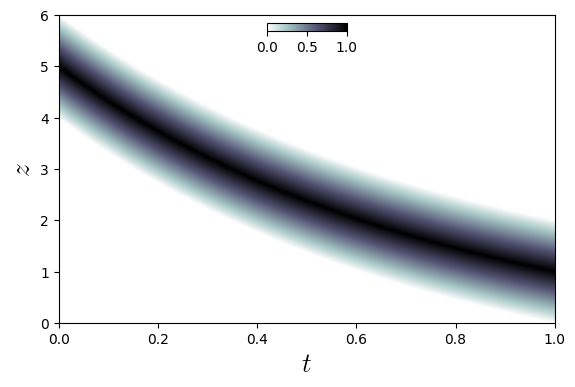

In [9]:
ul = np.load("solutions/din_1_fun_2_epoch11000.npy").ravel()
t = np.linspace(0,1,len(u)+1)
I,S = sol_levels(u,[x0-e,x0,x0+e],100)
n = len(I)
fig, ax = plt.subplots(figsize=(8, 4))
cmap = plt.get_cmap('bone_r')
for i in range(len(I)):
    fb = ax.fill_between(t, S[i,:], I[i,:], color=cmap(i/n))

ax.set_xlabel(r'$t$', fontsize=20, usetex=True)
ax.set_ylabel(r'$z$', fontsize=20, usetex=True)

ax.set_xlim([0,1])
ax.set_ylim([0,6])

cax, _ = cbar.make_axes(ax,aspect=0.1) 
cb = cbar.ColorbarBase(cax, cmap=plt.cm.bone_r,orientation="horizontal") 
cb.ax.set_position([0.385 ,0.8, 0.1,0.1])
cb.set_ticks([0,0.5,1])

plt.show()

In [ ]:
directory = os.getcwd()
extensao = ".npy"
files = os.listdir(os.path.join(directory, "solutions"))

filtered_files = sorted([file for file in files if file.endswith(extensao) and "din_1_fun_1" in file])
num_iter = len(filtered_files)

# Cria uma lista para armazenar as imagens em memória
images = []

# Loop pelas iterações
umin,umax = np.inf, -np.inf
x = np.linspace(0, T,n)
Y,FU = [],[]
for i in range(num_iter):
    data = np.load("solutions/"+filtered_files[i])
    # Cria os dados do gráfico
    y = data.ravel()
    Y.append(y)
    umin = min(umin,min(y))
    umax = max(umax,max(y))
    FU.append(funcional(y,gamma,beta,e,x0,T,alpha))


for i in range(num_iter):
   
    fig, ax = plt.subplots(figsize=(6.4,0.75*6.4))
    sns.lineplot(x=x, y=Y[i], ax=ax)
    ax.set(xlim=[0,1],ylim=[umin,umax])
    ax.set_xlabel(r'$t$',fontsize=16,usetex=True)
    ax.set_ylabel(r'$u(t)$',fontsize=16,usetex=True)
    pos = ax.get_position()
    
    # Adiciona o número da iteração no canto superior direito
    ax.text(0.95, 0.95, f'epoch: {10*i}', transform=ax.transAxes, ha='right', va='top')
    ax.text(pos.x0+0.1, 0.95, r'$J(u): {:.4f}$'.format(FU[i]), transform=ax.transAxes, ha='right', va='top',usetex=True)
    
    # Salva a figura em memória como uma imagem
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300)
    buffer.seek(0)
    image = Image.open(buffer)
    images.append(image)
    
    # Fecha a figura
    plt.close()

# Salva o GIF a partir das imagens em memória
images[0].save('animacao_din_1_fun_1.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=0)

# Apaga os arquivos numpy
# for file in filtered_files:
#     os.unlink(file)

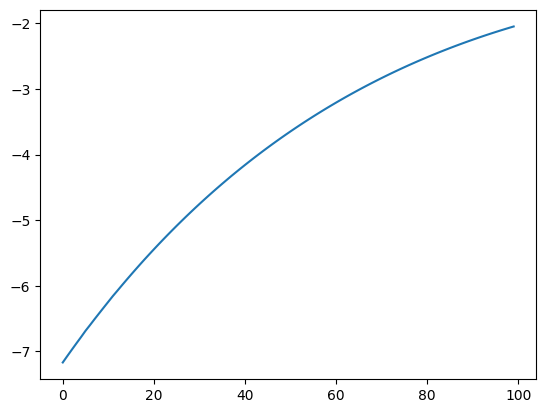

In [4]:
plt.plot(u)